In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import interactive, widgets
from IPython.display import display
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import sscfw.general

In [2]:
# finite volume approach. Label cell i from x_i to x_i+1. We have P = P_i on [x_i, x_i+1)
def prepare_grid(lbd_spl, N, factor):
    # linear with dx below lbd_spl
    # linear with 2 dx on lbd_spl, 2 lbd_spl
    # ...         4 dx   2         4
    cell_boundaries = np.linspace(0, lbd_spl, 2*N, endpoint=False)
    for i in range(factor):
        cell_boundaries = np.concatenate((cell_boundaries, np.linspace(2**i * lbd_spl, 2**(i+1) * lbd_spl, N, endpoint=False)))
    # add an extra point in the end
    cell_boundaries = np.concatenate((cell_boundaries, [2*cell_boundaries[-1] - cell_boundaries[-2]]))
    
    dx_array = cell_boundaries[1:] - cell_boundaries[:-1]
    cell_centers = 0.5 * (cell_boundaries[1:] + cell_boundaries[:-1])
    return cell_boundaries, dx_array, cell_centers

def g(x, kappa, k, eps):
    return kappa * np.exp(-k * x) + eps * x

def g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps):
    return kappa / k * np.exp(-k * cell_boundaries[:-1]) * (1. - np.exp(-k * dx_array)) + eps * dx_array * cell_centers

def g_mean(P, g_int_array, dx_array, kappa, k, eps):
    return np.sum(P * g_int_array) / np.sum(P * dx_array)

def v_M(x, P, g_int_array, dx_array, kappa, k, eps):
    return g_mean(P, g_int_array, dx_array, kappa, k, eps) - g(x, kappa, k, eps)
    # return 0.5 -  1 / (1 + np.exp(x - 6.32)) - eps * x
    
def rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, N):
    dx_array_theta = dx_array.copy()
    dx_array_theta[cell_boundaries[1:] <= lbd_spl+1e-10] = 0.
    rvec_out = -0.5 * dx_array_theta * (cell_centers - lbd_spl)
    rvec_in = dx_array_theta[N:] * (cell_centers[N:] - lbd_spl)
    return r * (np.diag(rvec_out) + np.diag(rvec_in, k = N))

def rhs(P, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat):
    v_M_array = v_M(cell_boundaries, P, g_int_array, dx_array, kappa, k, eps)
    mask = v_M_array > 0.
    # v_M_array = np.ones_like(cell_boundaries)
    v_M_array_pos = np.where(mask, v_M_array, 0)
    v_M_array_neg = np.where(~mask, v_M_array, 0)

        
    mat = (-np.diag(v_M_array_neg[1:-1], k=1) +
           np.diag(v_M_array_neg[:-1]) -
           np.diag(v_M_array_pos[1:]) + 
           np.diag(v_M_array_pos[1:-1], k=-1) + 
           rmat)
    
    center_inds = np.where(mask[:-1] != mask[1:])[0]
    if center_inds.size > 0:
        center_ind = center_inds[0]
        mat[center_ind, center_ind + 1] = -v_M_array_neg[1 + center_ind]/2
        mat[center_ind, center_ind - 1] = v_M_array_pos[1 + center_ind]/2
    # if len(center_inds) == 2:
    #     center_ind = center_inds[1]
    #     mat[center_ind, center_ind + 1] = -v_M_array_neg[1 + center_ind]/2
    #     mat[center_ind, center_ind - 1] = v_M_array_pos[1 + center_ind]/2
    # elif len(center_inds) > 2:
    #     raise ValueError
    #     mat = np.diag(v_M_array_0) - np.diag(v_M_array_1[:-1], k=1) + rmat
    return (mat.T / dx_array).T
        
def step(P, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat):
    P_new = P + dt * rhs(P, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat) @ P
    # P_new[-1] = P_new[-2] # fix bc
    return P_new

def evolve_P(n_steps, stride, P0, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, normalize=True, tqdm_bool=True, description='Evolving P '):
    P = P0.copy()
    stats = np.zeros((3, n_steps//stride))
    _range = tqdm(range(n_steps), desc=description) if tqdm_bool else range(n_steps)
    for i in _range:
        if i % stride == 0:
            rhs_mat = rhs(P, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
            _norm = np.sum(P * dx_array)
            _mean = np.sum(cell_centers * P * dx_array) / _norm
            stats[0, i // stride] = _norm
            stats[1, i // stride] = _mean
            stats[2, i // stride] = np.sqrt(np.sum((cell_centers - _mean)**2 * P * dx_array) / _norm)
        P += dt * rhs_mat @ P
    if normalize:
        P /= np.sum(P * dx_array)
    return P, stats

@sscfw.general.cache_numpys(num_of_returns=2)
def evolve_P_from_gauss(n_steps, stride, dt, n_grid, fact, kappa, k, eps, lbd_spl, r, mu, sig, normalize=True, n_precondition=2000):
    
    cell_boundaries, dx_array, cell_centers = prepare_grid(lbd_spl, n_grid, fact)
    rmat = rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, n_grid)    
    g_int_array= g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)
    
    P_ini = np.exp(- 0.5 * (cell_centers - mu)**2 / sig**2) / np.sqrt(2 * np.pi * sig**2)

    # preconditioning steps
    P_preconditioned, stats0 = evolve_P(n_precondition, 1, P_ini, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, normalize, description='Preconditioning: ')

    P_final, stats1 = evolve_P(n_steps, stride, P_preconditioned, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, normalize)

    return P_final, np.concatenate((stats0, stats1), axis=1)


In [67]:
from MFKSSteadyState import get_P_ss

lbd_spl = 37.5
r = 0.05
kappa = 0.2 #1 / (0.25 / 0.1**0.5 + 0.1 / 0.6 / 5)
k = 0.8 #1 / np.sqrt(0.1)
eps = 1e-12
xmax = 50
x_ss, P_ss = get_P_ss(xmax, kappa, k, eps, lbd_spl, r)


/home/n/Natan.Dominko/Documents/code/peaks_analysis/MFKSSteadyState.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  av_int = solve_ivp(lambda t, y: rate(t, lbd_spl, r) / v_Mss(t, g_avg, kappa, k, eps), t_span=(lbd_spl, lbd_upper), y0=[0.0], dense_output=True)
/usr/lib64/python3.9/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in divide
  return norm(self._estimate_error(K, h) / scale)
/home/n/Natan.Dominko/Documents/code/peaks_analysis/MFKSSteadyState.py:66: RuntimeWarning: overflow encountered in exp
  res = np.where((lbd > lbd_spl) & (lbd < lbd_inf), np.exp(-0.5*av_int.sol(lbd)), np.nan)


In [58]:
def get_P_ss_approx(x_array, lbd_0, kappa, k, eps, lbd_spl, r):
    g_avg = kappa * np.exp(-k * lbd_0) + eps * lbd_0
    vM_array = g_avg - (kappa * np.exp(-k * x_array) + eps * x_array)
    res = np.ones_like(x_array)
    mask_mid = (x_array >= lbd_spl/2) * (x_array <= lbd_spl)
    x_array_mid = x_array[mask_mid]
    res[mask_mid] = (np.exp(-r * (x_array_mid - 0.5*lbd_spl)**2 / g_avg) - np.exp(-r * (lbd_0 - 0.5*lbd_spl)**2 / g_avg)) / (1 - np.exp(-r * (lbd_0 - 0.5*lbd_spl)**2 / g_avg))
    mask_hi = x_array >= lbd_spl
    x_array_hi = x_array[mask_hi]
    res[mask_hi] = (np.exp(-r * 0.5**2 * lbd_spl**2 / g_avg) - np.exp(-r * (lbd_0 - 0.5*lbd_spl)**2 / g_avg)) / (1 - np.exp(-r * (lbd_0 - 0.5*lbd_spl)**2 / g_avg)) * np.exp(-r * (x_array_hi - lbd_spl)**2 / g_avg / 4)
    return np.nan_to_num(- res / vM_array)


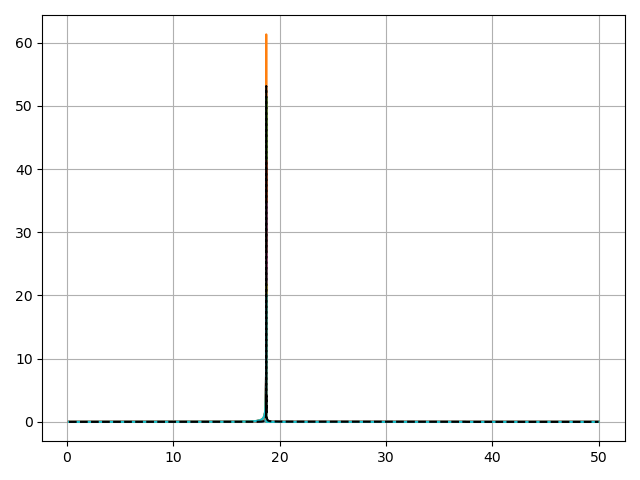

In [68]:
fig, ax = plt.subplots()
for d in np.linspace(0.001, 0.01, 10):
    lbd_0 = 0.5*lbd_spl + d
    P_ss_approx = get_P_ss_approx(x_ss, lbd_0, kappa, k, eps, lbd_spl, r)
    ax.plot(x_ss, P_ss_approx/np.trapz(P_ss_approx, x_ss))
    # ax.plot(x_ss, np.abs(P_ss_approx/np.trapz(P_ss_approx, x_ss)-P_ss))
    
ax.plot(x_ss, P_ss, 'k--')
# ax.set_yscale('log')
ax.grid()
plt.tight_layout()
plt.show()

In [4]:
n_grid = 50
lbd_spl = 7.5
fact = 1
cell_boundaries, dx_array, cell_centers = prepare_grid(lbd_spl, n_grid, fact)
n_cells = len(cell_boundaries) - 1

r = 0.05
rmat = rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, n_grid)

kappa = 1.2 #1 / (0.25 / 0.1**0.5 + 0.1 / 0.6 / 5)
k = 0.8 #1 / np.sqrt(0.1)
print(f'{k = }, {kappa = }')
eps = 0.0001

g_int_array = g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

P_ini = 1 * np.exp( - (cell_centers - 0.66 * lbd_spl)**2 / 0.3**2)

_, stat = evolve_P_from_gauss(10000, 100, 0.01, n_grid, fact, kappa, k, eps, lbd_spl, r, 5, 1)

from MFKSSteadyState import get_P_ss
xmax = 30
x_ss, P_ss = get_P_ss(xmax, kappa, k, eps, lbd_spl, r)
# print(f"{avg_bst = }")
# P_ss /= np.sum(P_ss * (x_ss[1] - x_ss[0]))
# fig, ax = plt.subplots()
# ax.plot(cell_centers, g_int_array, 'o-')
# ax.set_yscale('log')


k = 0.8, kappa = 1.2


/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


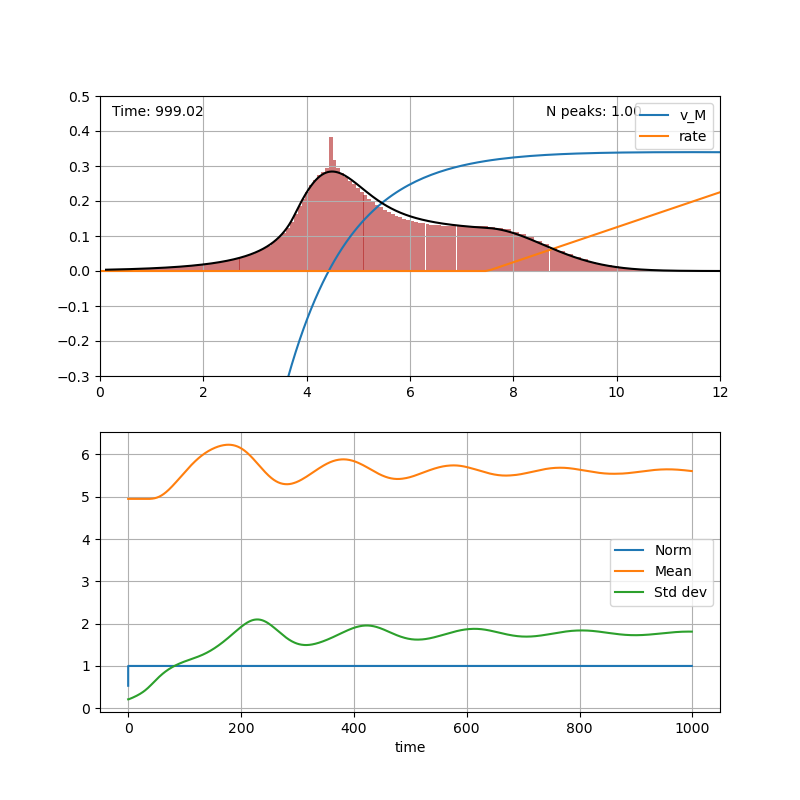

In [5]:
# animate P(t)
num_frames = 1000
dt = 0.01
stride = 100

# Initial state
P = P_ini

# Initialize plot
plt.close('all')
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
ax1 = axs[0]
bars = ax1.bar(cell_centers, P_ini, width=dx_array, color='firebrick', alpha=0.6)
vM_line, = ax1.plot(cell_centers, v_M(cell_centers, P_ini, g_int_array, dx_array, kappa, k, eps), label='v_M')
ax1.plot(cell_centers, r * np.maximum(0, cell_centers - lbd_spl), label='rate')
ax1.plot(x_ss, P_ss, 'k')
time_text = ax1.text(0.02, 0.93, '', transform=ax1.transAxes)
sum_text = ax1.text(0.72, 0.93, '', transform=ax1.transAxes)
ax1.legend()
ax1.grid()

# Variables to store statistics over time
times = []
stats1 = []
stats2 = []
stats3 = []

# Initialize second plot
ax2 = axs[1]
m0_line, = ax2.plot([], [], label='Norm')
m1_line, = ax2.plot([], [], label='Mean')
m2_line, = ax2.plot([], [], label='Std dev')
ax2.set_xlabel('time')
ax2.legend()
ax2.grid()

# Update function for animation
t = 0
frame = 1
def update(frame):
    global P, t, times, stats1, stats2, stats3
    _stride = stride if frame > 0 else 1
    t += _stride * dt
    P, stats = evolve_P(_stride, _stride, P, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=False)
    
    # Update the bar heights
    for bar, height in zip(bars, P):
        bar.set_height(height)
    
    # Update vM line
    vM_line.set_ydata(10 * v_M(cell_centers, P, g_int_array, dx_array, kappa, k, eps))
    
    # Update text annotations
    time_text.set_text(f'Time: {t:.2f}')
    sum_text.set_text(f'N peaks: {np.sum(P * dx_array):.2f}')
    
    # Append new statistics
    times.append(t)
    stats1.append(stats[0,0])  # Assuming stats returns a list/array of statistics
    stats2.append(stats[1,0])
    stats3.append(stats[2,0])
    
    # Update statistics plots
    m0_line.set_data(times, stats1)
    m1_line.set_data(times, stats2)
    m2_line.set_data(times, stats3)
    
    ax1.set_xlim(0, 12)
    ax1.set_ylim(-0.3, 0.5)
    
    ax2.relim()
    ax2.autoscale_view()

    return bars, vM_line, time_text, sum_text, m0_line, m1_line, m2_line

# Create animation
ani = FuncAnimation(fig, update, frames=num_frames, blit=True, repeat=False, interval=1)
# ani.save('works.gif')

# Display animation
plt.tight_layout()
plt.show()


In [5]:
# evolve without animating
N = 20
lbd_spl = 7.5
fact = 1
cell_boundaries, dx_array, cell_centers = prepare_grid(lbd_spl, N, fact)
n_cells = len(cell_boundaries) - 1

r = 0.2
rmat = rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, N)

kappa = 1 / (0.25 / 0.1**0.5 + 0.1 / 0.6 / 5)
k = 1 / np.sqrt(0.1)
print(f'{k = }, {kappa = }')
eps = 0.0

g_int_array = g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

P_ini = 1 * np.exp( - (cell_centers - 0.75 * lbd_spl)**2 / 1.3**2)

plt.close('all')
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
fig, ax = plt.subplots()
    
# precondition
n_steps = 20000
dt = 1e-2
stride = 1

P1, stats0 = evolve_P(n_steps, stride, P_ini, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)

# evolve faster
n_steps = 10000000
dt = 1e-2
stride = 1000

P, stats = evolve_P(n_steps, stride, P1, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)

i = 0
ax.plot(stats0[1, :], stats0[2, :], color=colors[i%10])
ax.plot(stats[1, :], stats[2, :], color=colors[i%10])
ax.scatter(stats0[1, 0], stats0[2, 0])
ax.grid()
plt.show()

NameError: name 'prepare_grid' is not defined

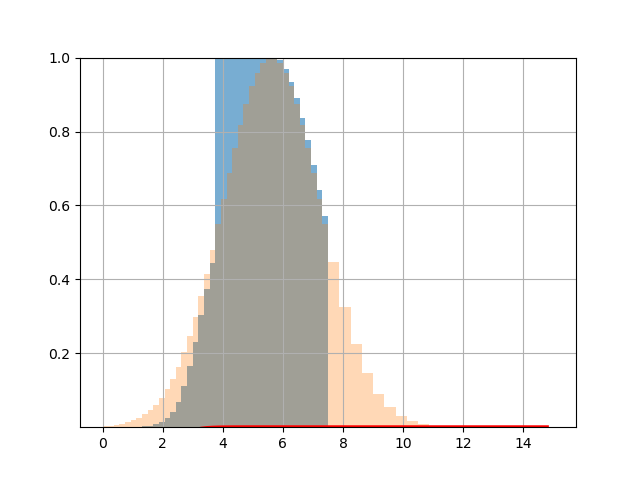

In [17]:
fig, ax = plt.subplots()
ax.bar(cell_centers, P, width=dx_array, alpha=0.6, color='C0')
ax.bar(cell_centers, P_ini, width=dx_array, alpha=0.3, color='C1')
ax.plot(cell_centers, 100*v_M(cell_centers, P, g_int_array, dx_array, kappa, k, eps), color='red', label='v_M')
# ax.set_yscale('log')
ax.grid()
ax.set_ybound(1e-5, 1)

k = 3.162277660168379, kappa = 1.2137354827032687


Evolving P: 100%|█████████████████| 2000000/2000000 [00:09<00:00, 217883.69it/s]


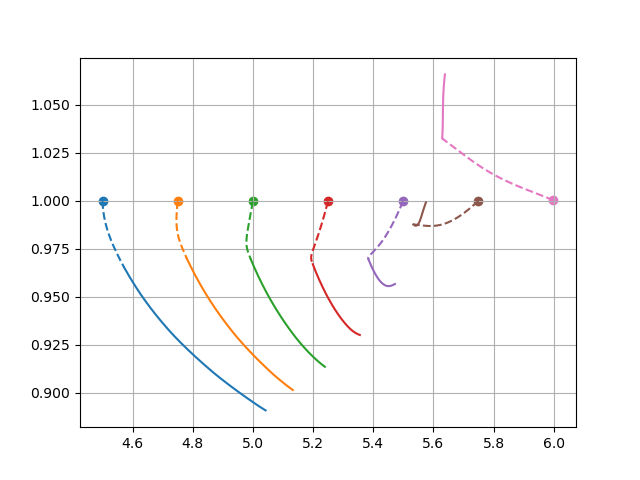

In [11]:
# evolve without animating (many initial positions)
N = 20
lbd_spl = 7.5
fact = 1
cell_boundaries, dx_array, cell_centers = prepare_grid(lbd_spl, N, fact)
n_cells = len(cell_boundaries) - 1

r = 0.2
rmat = rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, N)

kappa = 1 / (0.25 / 0.1**0.5 + 0.1 / 0.6 / 5)
k = 1 / np.sqrt(0.1)
print(f'{k = }, {kappa = }')
eps = 0.0

g_int_array = g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

P_ini = 1 * np.exp( - (cell_centers - 0.75 * lbd_spl)**2 / 2.3**2)

plt.close('all')
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
fig, ax = plt.subplots()
for i, _fact in enumerate(np.linspace(0.6, 0.8, 7, endpoint=True)):
    P_ini = np.exp( - (cell_centers - _fact * lbd_spl)**2 / 1.0**2 / 2)
    
    # precondition
    n_steps = 20000
    dt = 1e-2
    stride = 1
    
    P1, stats0 = evolve_P(n_steps, stride, P_ini, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
    
    # evolve faster
    n_steps = 10000000
    dt = 1e-2
    stride = 10000
    
    P, stats = evolve_P(n_steps, stride, P1, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
    
    ax.plot(stats0[1, :], stats0[2, :], color=colors[i%10], linestyle='--')
    ax.plot(stats[1, :], stats[2, :], color=colors[i%10])
    ax.scatter(stats0[1, 0], stats0[2, 0])
ax.grid()

In [3]:
N = 20
lbd_spl = 7.5
fact = 1
cell_boundaries, dx_array, cell_centers = prepare_grid(lbd_spl, N, fact)
n_cells = len(cell_boundaries) - 1

r = 0.03
rmat = rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, N)

kappa = 1.2
k = 1.2
eps = 0.0

g_int_array = g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

P_ini = 1 * np.exp( - (cell_centers - 0.75 * lbd_spl)**2 / 2.3**2)

Evolving P: 100%|████████████████████████| 1000/1000 [00:00<00:00, 12577.42it/s]


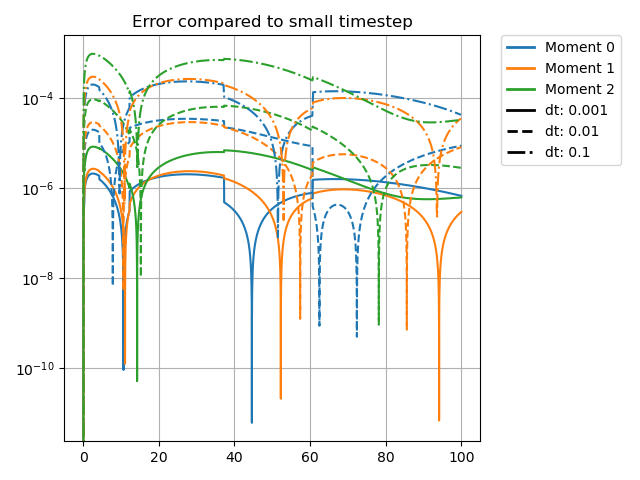

In [35]:
# show effect of timesteps 
fig, ax = plt.subplots()

# prepare  
t_final = 100

# baseline
n_steps = 1000000
dt = t_final / n_steps
_, stats_full = evolve_P(n_steps, 1, P_ini, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)

colors = ['C0', 'C1', 'C2']
line_styles = ['-', '--', '-.', ':']

n_stepss = [100000, 10000, 1000]
for ls_ind, n_steps in enumerate(n_stepss):
    dt = t_final / n_steps
    t_array = np.arange(n_steps)*dt 

    _, stats = evolve_P(n_steps, 1, P_ini, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
    for i in [0, 1, 2]:
        ax.plot(t_array, np.abs(stats[i,:] - stats_full[i, ::10**(1 + ls_ind)]), color=colors[i], linestyle=line_styles[ls_ind], label=f"moment = {i}, {dt = }")

# Create custom legend handles
color_handles = [Line2D([0], [0], color=colors[i], lw=2, label=f'Moment {i}') for i in range(3)]
style_handles = [Line2D([0], [0], color='k', linestyle=line_styles[i], lw=2, label=f'dt: {t_final / n_stepss[i]}') for i in range(len(n_stepss))]

# Add legend
ax.legend(handles=color_handles + style_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_title('Error compared to small timestep')
ax.grid()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

Evolving P: 100%|███████████████████| 100000/100000 [00:00<00:00, 184380.73it/s]


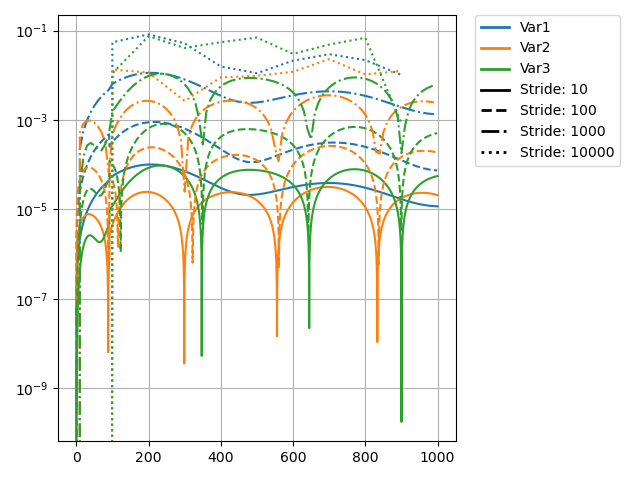

In [28]:
# show effect of stride 
from matplotlib.lines import Line2D
fig, ax = plt.subplots()

# prepare
n_steps = 10000
dt = 1e-2
P_first, _ = evolve_P(n_steps, 1, P_ini, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
    
n_steps = 100000
dt = 1e-2
t_array = np.arange(n_steps)*dt 

colors = ['C0', 'C1', 'C2']
line_styles = ['-', '--', '-.', ':']

_, stats_full = evolve_P(n_steps, 1, P_first, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)

strides = [10, 100, 1000, 10000]
for ls_ind, stride in enumerate(strides):
    _, stats = evolve_P(n_steps, stride, P_first, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
    for i in [0, 1, 2]:
        ax.plot(t_array[::stride], np.abs(stats[i,:] - stats_full[i, ::stride]), color=colors[i], linestyle=line_styles[ls_ind], label=f"moment = {i}, {stride = }")

# Create custom legend handles
color_handles = [Line2D([0], [0], color=colors[i], lw=2, label=f'Moment {i}') for i in range(3)]
style_handles = [Line2D([0], [0], color='k', linestyle=line_styles[i], lw=2, label=f'Stride: {strides[i]}') for i in range(len(strides))]

# Add legend
ax.legend(handles=color_handles + style_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_title('Error compared to stride 1')
ax.grid()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

k = 3.162277660168379, kappa = 1.2137354827032687


Evolving P:  27%|████▍           | 5492088/20000000 [00:25<01:16, 190794.45it/s]

k = 3.162277660168379, kappa = 1.2137354827032687


Evolving P: 100%|███████████████████████████████| 1/1 [00:00<00:00, 1123.88it/s]


[-8.75517378e-06 -7.33546140e-06 -7.33546140e-06 -6.00939607e-06
 -6.00939607e-06 -4.90919557e-06 -4.90919557e-06 -4.13580924e-06
 -4.13580924e-06 -3.81188072e-06]
Selected eigenvector with eigval (-3.8118807198097846e-06+0j)


Evolving P: 100%|███████████████████████████████| 1/1 [00:00<00:00, 1119.68it/s]

[-6.73646050e-05 -6.28090312e-05 -5.60377161e-05 -3.87904282e-05
 -3.87904282e-05 -1.61091105e-05 -1.61091105e-05 -1.54383475e-06
 -1.54383475e-06  3.47567205e-06]
Selected eigenvector with eigval (3.4756720516324558e-06+0j)


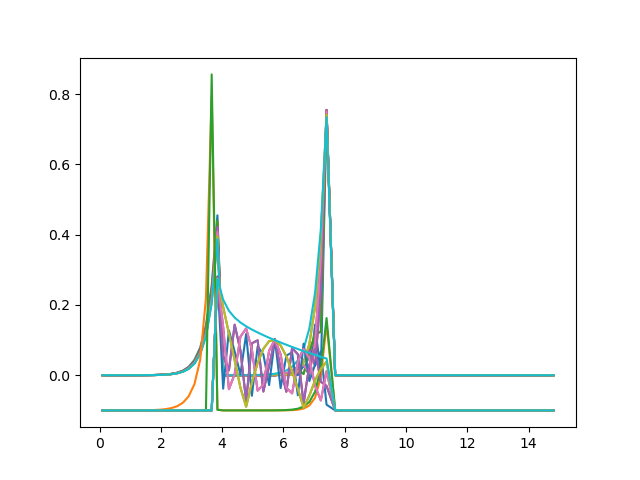

In [31]:
# ultimate speed up: matrix eigendecomposition
N = 20
lbd_spl = 7.5
fact = 1
cell_boundaries, dx_array, cell_centers = prepare_grid(lbd_spl, N, fact)
n_cells = len(cell_boundaries) - 1

r = 0.2
rmat = rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, N)

kappa = 1 / (0.25 / 0.1**0.5 + 0.1 / 0.6 / 5)
k = 1 / np.sqrt(0.1)
print(f'{k = }, {kappa = }')
eps = 0.0

g_int_array = g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

P_ini = 1 * np.exp( - (cell_centers - 0.75 * lbd_spl)**2 / 1.3**2)
    
# precondition
n_steps = 200
dt = 1e-2
stride = 1
P0, stats0 = evolve_P(n_steps, stride, P_ini, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
fig, ax = plt.subplots()

n_steps = 1
dt = 1e-2
stride = 1
for i in range(2):
    P0, stats0 = evolve_P(n_steps, stride, P0, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
    
    # get rhs matrix
    rhs_mat = rhs(P0, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(rhs_mat)
    print(np.sort(eigenvalues.real)[-10:])
    
    # Identify the eigenvalue with the largest real part
    # index_of_largest_real_part = np.argsort(eigenvalues.real)[-1]
    indeces_of_largest_real_part = np.argsort(eigenvalues.real)[-10:]
    
    # Select the corresponding eigenvector
    for index_of_largest_real_part in indeces_of_largest_real_part:
        P0 = np.real(eigenvectors[:, index_of_largest_real_part])
        ax.plot(cell_centers, np.abs(P0)-0.1*i)
    print(f'Selected eigenvector with eigval {eigenvalues[index_of_largest_real_part]}')


In [4]:
from MFKSSteadyState import get_P_ss 
lbd_spl = 7.5
r = 0.5
kappa = 1.2 #1 / (0.25 / 0.1**0.5 + 0.1 / 0.6 / 5)
k = 0.8 #1 / np.sqrt(0.1)
eps = 1e-3
dx = 1e-3
lbd_max = 30

x_range, P_range = get_P_ss(lbd_max, kappa, k, eps, lbd_spl, r, dx)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Layout
from matplotlib.colors import LogNorm
from MFKSSteadyState import get_P_ss, parameter_control
from MFKSGaussClosure import mu_sig_prime, get_traj

num_frames = 1000000
stride = 1000
dt = 0.01
n_grid = 40
fact = 1

x = np.linspace(0, 10, 100)
y = np.linspace(0.001, 2.5, 100)
X, Y = np.meshgrid(x, y)
mask = X - 2*Y < 0


# Define a function to update the plot
def update_plot(lbd_spl, r, kappa, k, xmax, eps, dx, mu, sig):
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 6))
    if parameter_control(kappa, k, eps, lbd_spl):
        lbd_array, P_array = get_P_ss(xmax, kappa, k, eps, lbd_spl, r, dx)
        ax1.plot(lbd_array, P_array, 'k', label='Steady state')
        # x_range, P_range, _ = get_P_ss(xmax, kappa, k, 0.0, lbd_spl, r, dx)
        # plt.plot(x_range, P_range, 'r--', label='Steady state eps=0')

    # get and plot full evolution
    cell_boundaries, dx_array, cell_centers = prepare_grid(lbd_spl, n_grid, fact)
    P_final, stats_evo = evolve_P_from_gauss(num_frames, stride, dt, n_grid, fact, kappa, k, eps, lbd_spl, r, mu, sig)
    ax1.step(cell_centers, np.exp(-0.5*(cell_centers-mu)**2/sig**2)/np.sqrt(2*np.pi*sig**2), where='mid', color='gold', label=f'P(λ,T = 0)')
    ax1.bar(cell_centers, P_final, width=dx_array, color='firebrick', alpha=0.6, label=f'P(λ,T = {num_frames*dt})')
    ax2.plot(stats_evo[1, :], stats_evo[2, :], color='firebrick', label='full evo')

    # get and plot gaussian field 
    U, V = mu_sig_prime((X, Y), kappa, k, eps, lbd_spl, r)
    U[mask] = V[mask] = np.nan
    strm = ax2.streamplot(X, Y, U, V, color=np.sqrt(U**2 + V**2), density=1.6, cmap='winter', norm=LogNorm(1e-7, 1e-1))
    ax2.scatter([mu], [sig], c='gold', label='initial')

    # get and plot specific gaussian realisation
    # mu_gauss, sig_gauss = get_traj(mu, sig, kappa, k, eps, lbd_spl, r)
    # ax2.plot(mu_gauss, sig_gauss, 'k', label='gaussian evo')
    
    ax1.set_xlabel('lambda')
    ax1.set_xlim(0, 2 * lbd_spl)
    ax1.legend()
    ax1.grid()
    
    ax2.set_xlim(np.min(x),np.max(x))
    ax2.set_ylim(np.min(y),np.max(y))
    ax2.set_xlabel('mu')
    ax2.set_ylabel('sig')
    ax2.legend()
    ax2.grid()
    
    fig.colorbar(strm.lines)
    
    plt.tight_layout()
    plt.show()

# Create interactive sliders
lbd_spl_slider = FloatSlider(value=7.5, min=6.0, max=9.0, step=0.1, description='λ:', layout=Layout(width='500px'), continuous_update=False)
r_slider = FloatSlider(value=0.5, min=0.1, max=1.0, step=0.1, description='r:', layout=Layout(width='500px'), continuous_update=False)
kappa_slider = FloatSlider(value=1.2, min=1.0, max=1.5, step=0.1, description='κ:', layout=Layout(width='500px'), continuous_update=False)
k_slider = FloatSlider(value=1.0, min=0.5, max=1.0, step=0.1, description='k:', layout=Layout(width='500px'), continuous_update=False)
xmax_slider = IntSlider(value=30, min=10, max=50, step=1, description='xmax:', layout=Layout(width='500px'), continuous_update=False)
eps_slider = FloatSlider(value=3e-3, min=0, max=1e-2, step=1e-4, description='eps:', readout_format='.1e', layout=Layout(width='500px'), continuous_update=False)
dx_slider = FloatSlider(value=1e-3, min=1e-4, max=1e-2, step=1e-4, description='dx:', readout_format='.1e', layout=Layout(width='500px'), continuous_update=False)
mu_slider = FloatSlider(value=6, min=2.0, max=8.0, step=0.1, description='mu_ini:', layout=Layout(width='500px'), continuous_update=False)
sig_slider = FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='sig_ini:', layout=Layout(width='500px'), continuous_update=False)

# Use interact to create the interactive plot
interact(update_plot, lbd_spl=lbd_spl_slider, r=r_slider, kappa=kappa_slider, k=k_slider, xmax=xmax_slider, eps=eps_slider, dx=dx_slider, mu=mu_slider, sig=sig_slider)
    

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


interactive(children=(FloatSlider(value=7.5, continuous_update=False, description='λ:', layout=Layout(width='5…

<function __main__.update_plot(lbd_spl, r, kappa, k, xmax, eps, dx, mu, sig)>

In [3]:
def peak_mass(Drho, Dc, T):
    return np.sqrt(12 * Drho * Dc / T)

def lbd_spl_eps(eps):
    if eps == 0.0:
        return np.inf 
    else:
        return np.exp(1.13734914) * eps**(-0.3579829)

def reparameterize(Drho, Dc, T, epsilon, r):
    M = peak_mass(Drho, Dc, T)
    kappa = 1 / (1 / 4 / np.sqrt(Dc) + 1 / M / T)
    k = 1 / np.sqrt(Dc) 
    eps = 4 * epsilon * np.exp(-T * M / 2 / Drho / np.sqrt(Dc))
    lbd_spl = lbd_spl_eps(epsilon)
    return kappa, k, eps, lbd_spl, r

In [6]:
# reparameterized to real parameters
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Layout
from matplotlib.colors import LogNorm
from MFKSSteadyState import get_P_ss, parameter_control, get_lbd_inf, g
from MFKSGaussClosure import mu_sig_prime, get_traj

num_frames = 1000000
stride = 10000
dt = 0.01
n_grid = 40
fact = 1


# Define a function to update the plot
def update_plot(Drho, Dc, T, epsilon, r, xmax, dx, mu, sig):

    kappa, k, eps, lbd_spl, r = reparameterize(Drho, Dc, T, epsilon, r)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 6))
    if parameter_control(kappa, k, eps, lbd_spl):
        lbd_array, P_array = get_P_ss(xmax, kappa, k, eps, lbd_spl, r, dx)
        ax1.plot(lbd_array, P_array, 'k', label='Steady state')
        ss_mean = np.trapz(P_array * lbd_array, lbd_array)
        ax2.scatter([ss_mean], [np.sqrt(np.trapz(P_array * (lbd_array - ss_mean)**2, lbd_array))], color='green', label='Steady state')
        # g_avg = np.trapz(P_array * g(lbd_array, kappa, k, eps), lbd_array)
        # lbd_inf = get_lbd_inf(g_avg, kappa, k, eps)
        # print(f'{lbd_inf = }')
    # else:
        # lbd_inf = 20.
        # x_range, P_range, _ = get_P_ss(xmax, kappa, k, 0.0, lbd_spl, r, dx)
        # plt.plot(x_range, P_range, 'r--', label='Steady state eps=0')

    # get and plot full evolution
    cell_boundaries, dx_array, cell_centers = prepare_grid(lbd_spl, n_grid, fact)
    P_final, stats_evo = evolve_P_from_gauss(num_frames, stride, dt, n_grid, fact, kappa, k, eps, lbd_spl, r, mu, sig)
    ax1.step(cell_centers, np.exp(-0.5*(cell_centers-mu)**2/sig**2)/np.sqrt(2*np.pi*sig**2), where='mid', color='gold', label=f'P(λ,T = 0)')
    ax1.bar(cell_centers, P_final, width=dx_array, color='firebrick', alpha=0.6, label=f'P(λ,T = {num_frames*dt})')
    ax2.plot(stats_evo[1, :], stats_evo[2, :], color='firebrick', label='full evo')
    
    # get and plot gaussian field 
    x = np.linspace(0, 30, 100)
    y = np.linspace(0.001, 5, 100)
    X, Y = np.meshgrid(x, y)
    # mask = X - 2*Y < 0
    U, V = mu_sig_prime((X, Y), kappa, k, eps, lbd_spl, r)
    # U[mask] = V[mask] = np.nan
    strm = ax2.streamplot(X, Y, U, V, color=np.sqrt(U**2 + V**2), density=1.6, cmap='winter', norm=LogNorm(1e-7, 1e-1))
    ax2.scatter([mu], [sig], c='gold', label='initial')

    # _a = r / (2 * np.sqrt(2 * np.pi))
    # _b = kappa * (np.exp(-k * x) - 1) - r / 4 * (lbd_spl - x)
    # _c = x * kappa * np.exp(-k * x) / np.sqrt(2 * np.pi)
    
    # ax2.plot(x, (-_b - np.sqrt(_b**2 - 4*_a*_c))/2/_a, 'k--')

    # get and plot specific gaussian realisation
    # mu_gauss, sig_gauss = get_traj(mu, sig, kappa, k, eps, lbd_spl, r)
    # ax2.plot(mu_gauss, sig_gauss, 'k', label='gaussian evo')
    # ax1.axvspan(xmin=lbd_inf, xmax=np.max(lbd_array), color='gray', alpha=0.3)
    
    ax1.set_xlabel('lambda')
    _xlim_up = min(2*lbd_spl, 2*np.max(cell_centers), 20)
    ax1.set_xlim(0, _xlim_up)
    ax1.legend()
    ax1.grid()
    
    ax2.set_xlim(np.min(x),np.max(x))
    ax2.set_ylim(np.min(y),np.max(y))
    ax2.set_xlabel('mu')
    ax2.set_ylabel('sig')
    ax2.legend()
    ax2.grid()
    
    fig.colorbar(strm.lines)
    
    plt.tight_layout()
    plt.show()

# Create interactive sliders
Drho_slider = FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='D_rho:', layout=Layout(width='500px'), continuous_update=False)
Dc_slider = FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='D_c:', layout=Layout(width='500px'), continuous_update=False)
T_slider = FloatSlider(value=5.0, min=0.5, max=10.0, step=0.1, description='T:', layout=Layout(width='500px'), continuous_update=False)
epsilon_slider = FloatSlider(value=1e-2, min=0, max=1e-1, step=1e-3, description='epsilon:', readout_format='.2e', layout=Layout(width='500px'), continuous_update=False)
r_slider = FloatSlider(value=0.04, min=0.001, max=1.0, step=1e-3, description='r:', readout_format='.1e', layout=Layout(width='500px'), continuous_update=False)
xmax_slider = IntSlider(value=30, min=10, max=50, step=1, description='xmax:', layout=Layout(width='500px'), continuous_update=False)
dx_slider = FloatSlider(value=1e-3, min=1e-4, max=1e-2, step=1e-4, description='dx:', readout_format='.1e', layout=Layout(width='500px'), continuous_update=False)
mu_slider = FloatSlider(value=6, min=2.0, max=22.0, step=0.1, description='mu_ini:', layout=Layout(width='500px'), continuous_update=False)
sig_slider = FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='sig_ini:', layout=Layout(width='500px'), continuous_update=False)

# Use interact to create the interactive plot
interact(update_plot, Drho=Drho_slider, Dc=Dc_slider, T=T_slider, epsilon=epsilon_slider, r=r_slider, xmax=xmax_slider, dx=dx_slider, mu=mu_slider, sig=sig_slider) 

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='D_rho:', layout=Layout(widt…

<function __main__.update_plot(Drho, Dc, T, epsilon, r, xmax, dx, mu, sig)>

## Trash

In [ ]:
# steady state
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from scipy.integrate import cumulative_trapezoid, solve_ivp
from scipy.interpolate import Akima1DInterpolator
from scipy.optimize import bisect
from scipy.special import spence
from tqdm import tqdm

def rate(lbd, lbd_spl, r):
    return np.maximum(0, r * (lbd - lbd_spl))

def g(x, kappa, k, eps):
    return kappa * np.exp(-k*x) + eps * x

def v_Mss(x, avg, kappa, k, eps):
    return avg - g(x, kappa, k, eps)

def get_lbd_inf(avg, kappa, k, eps):
    if eps == 0.:
        return np.inf
    else:
        xleft = -1 / k * np.log(eps / kappa / k) # location of maximum of v_Mss
        assert v_Mss(xleft, avg, kappa, k, eps) > 0, f"Assumed v_M(.) > 0 but instead is {v_Mss(xleft, avg, kappa, k, eps)}"
        xright= avg / eps + 1 # zero if k = inf
        return bisect(v_Mss, xleft, xright, args=(avg, kappa, k, eps)) - 3e-12 # ensure the root found is always < real root
        
def get_lbd_0(avg, kappa, k, eps):
    if eps == 0.:
        return - 1 / k * np.log(avg / kappa)
    else:
        xright = -1 / k * np.log(eps / kappa / k) # location of maximum of v_Mss
        assert v_Mss(xright, avg, kappa, k, eps) > 0,  f"Assumed v_M(.) > 0 but instead is {v_Mss(xright, avg, kappa, k, eps)}"
        xleft= -1 / k * np.log(avg/kappa) # zero if eps = 0
        return bisect(v_Mss, xleft, xright, args=(avg, kappa, k, eps)) + 3e-12 # ensure the root found is always > real root

def cumulative_trapezoid_reversed(y, x, final_value):
    return cumulative_trapezoid(y[::-1], x[::-1], initial=0)[::-1] + final_value

def parameter_control(kappa, k, eps, lbd_spl):
    avg_min = g(lbd_spl, kappa, k, eps)
    avg_max = g(lbd_spl/2, kappa, k, eps)
    if avg_min < avg_max:
        return True
    else:
        print("Parameters do not produce a steady state solution."  )
        return False


def p_hom_global(x, x_left, x_right, lbd_inf, avg, kappa, k, eps, lbd_spl, r):
    if eps == 0.0:
        y = k * (x - lbd_spl)
        u0= kappa / avg * np.exp(-k * lbd_spl)
        print(u0)
        u = u0 * np.exp(-y)
        res = np.exp(- 0.5 * r / avg / k**2 * (
            0.5 * np.log(u/u0)**2 -
            np.log(1 - u) * np.log(u/u0) -
            spence(1 - u) + 
            spence(1 - u0)))
        return np.where(x <= x_left, 1, res)
    
    lbd_upper = lbd_inf#min(lbd_inf, -1 / k * np.log(1e-15/kappa))
    av_int = solve_ivp(lambda t, y: rate(t, lbd_spl, r) / v_Mss(t, avg, kappa, k, eps), t_span=(lbd_spl, lbd_upper), y0=[0.0], dense_output=True)
    x = np.asarray(x)  # Ensure x is a numpy array
    res = np.where((x > x_left) & (x < x_right), np.exp(-0.5*av_int.sol(x)), np.nan)
    return np.where(x <= x_left, 1, np.where(x >= x_right, 0, res))[0]

def log_p_hom_global(x, x_left, x_right, lbd_inf, avg, kappa, k, eps, lbd_spl, r):
    if eps == 0.0:
        u0 = kappa * np.exp(-k * lbd_spl) / avg
        # res =  np.exp(- 0.5 * r / avg / k**2 * (
        #     0.5 * k**2 * (x - lbd_spl)**2 +
        #     k * (x - lbd_spl) * np.log(1 - u0 * np.exp(-k * (x - lbd_spl))) - 
        #     spence(u0 * np.exp(-k * (x - lbd_spl))) + 
        #     spence(u0) 
        # ))
        res =  np.exp(- 0.5 * r / avg * (
            0.5 * (x - lbd_spl)**2 - 
            1 / k**2  * spence(1 - u0 * np.exp(-k * (x - lbd_spl))) + 
            1 / k**2  * spence(1 - u0) 
        )) * (1 - u0 * np.exp(-k * (x - lbd_spl))) ** (-0.5 * r / avg / k * (x - lbd_spl))
        return np.where(x <= x_left, 1, res)
    
    lbd_upper = lbd_inf#min(lbd_inf, -1 / k * np.log(1e-15/kappa))
    av_int = solve_ivp(lambda t, y: rate(t, lbd_spl, r) / v_Mss(t, avg, kappa, k, eps), t_span=(lbd_spl, lbd_upper), y0=[0.0], dense_output=True)
    x = np.asarray(x)  # Ensure x is a numpy array
    res = np.where((x > x_left) & (x < x_right), -0.5*av_int.sol(x), np.nan)
    return np.where(x <= x_left, 0, np.where(x >= x_right, -np.inf, res))[0]


def get_particular(lbd_array_current, lbd_array_full, P_array_full, lbd_inf, avg, kappa, k, eps, lbd_spl, r):
    
    # interpolate P on the known interval
    P_full_intepr = Akima1DInterpolator(lbd_array_full, P_array_full)

    # evaluate particular_prime on lbd_array_current
    rate_P_2 = 2 * rate(2 * lbd_array_current, lbd_spl, r) * P_full_intepr(2 * lbd_array_current)
    p_hom_array = p_hom_global(lbd_array_current, lbd_spl, lbd_inf, lbd_inf, avg, kappa, k, eps, lbd_spl, r)
    with np.errstate(divide='ignore', invalid='ignore'): # safe division
        particular_prime = np.true_divide(rate_P_2, p_hom_array)
        particular_prime = np.nan_to_num(particular_prime, nan=0.0)

    # boundary condition (safe)
    final = -1.0
    p_hom_0 = p_hom_global(x_array_full[0], lbd_spl, lbd_inf, lbd_inf, avg, kappa, k, eps, lbd_spl, r)
    if p_hom_0 > 0.0:
        final += P_array_full[0] * v_Mss(x_array_full[0], avg, kappa, k, eps) / p_hom_0
        
    # integrate from above
    return cumulative_trapezoid_reversed(particular_prime, lbd_array_current, final_value=final) 


def P_solve(x_array_current, x_array_full, P_array_full, lbd_inf, avg, kappa, k, eps, lbd_spl, r):
    # given P on some array, estimate it on another array 
    # interpolate on the known interval
    P_full_intepr = Akima1DInterpolator(x_array_full, P_array_full)

    rate_P_2 = 2 * rate(2 * x_array_current, lbd_spl, r) * P_full_intepr(2 * x_array_current)

    p_hom_array = p_hom_global(x_array_current, lbd_spl, lbd_inf, lbd_inf, avg, kappa, k, eps, lbd_spl, r)

    # safe division
    with np.errstate(divide='ignore', invalid='ignore'): 
        integrand = np.true_divide(rate_P_2, p_hom_array)
        integrand = np.nan_to_num(integrand, nan=0.0)

    # ensure continuity
    final = -1.0
    p_hom_0 = p_hom_global(x_array_full[0], lbd_spl, lbd_inf, lbd_inf, avg, kappa, k, eps, lbd_spl, r)
    if p_hom_0 > 0.0:
        final += P_full_intepr(x_array_full[0]) * v_Mss(x_array_full[0], avg, kappa, k, eps) / p_hom_0
        
    # integrate from above
    particular = cumulative_trapezoid_reversed(integrand, x_array_current, final_value=final) 
    if np.all(v_Mss(x_array_current, avg, kappa, k, eps) > 0):
        # print('Used log divide')
        res = np.exp(log_p_hom_global(x_array_current, lbd_spl, lbd_inf, lbd_inf, avg, kappa, k, eps, lbd_spl, r) - 
                         np.log(v_Mss(x_array_current, avg, kappa, k, eps)))
    else:
        # safe division
        with np.errstate(divide='ignore', invalid='ignore'):
            res = np.true_divide(p_hom_array, v_Mss(x_array_current, avg, kappa, k, eps))
            res = np.nan_to_num(res, nan=0.0)


    return res * (np.ones_like(x_array_current) + particular)


def cascade_solve_P(lbd_max, lbd_inf, avg, kappa, k, eps, lbd_spl, r, dx, lbd_lim_left, verbose):    

    # if lbd_inf is outside the interval, inform the user of the approximation
    if lbd_max < lbd_inf: 
        print(f"We have lbd_max < lbd_inf, homogeneous approximation will be made. ")

    # on initial interval, the solution is homogeneous 
    lbd_max = min(lbd_max, lbd_inf)
    lbd_min, lbd_max = 0.5*lbd_max, lbd_max
    x_array_full = np.arange(lbd_min, lbd_max, dx)
    P_array_full = p_hom_global(x_array_full, lbd_spl, lbd_inf, lbd_inf, avg, kappa, k, eps, lbd_spl, r) / v_Mss(x_array_full, avg, kappa, k, eps)

    # update to new interval
    lbd_min, lbd_max = 0.5*lbd_min, lbd_min

    # loop through intervals to the left
    while lbd_min > lbd_lim_left:
        
        # solve on current interval
        x_array_current = np.arange(lbd_min, lbd_max, dx)
        P_array_current = P_solve(x_array_current, x_array_full, P_array_full, lbd_inf, avg, kappa, k, eps, lbd_spl, r)
        
        if verbose: 
            print(f'Dealing with {lbd_min, lbd_max}. Maximum of P here is {np.max(P_array_current)}. ')

        # update solutions
        x_array_full = np.concatenate((x_array_current, x_array_full))
        P_array_full = np.concatenate((P_array_current, P_array_full))
        
        # update interval
        lbd_min, lbd_max = 0.5*lbd_min, lbd_min

    return x_array_full, P_array_full


def find_leftmost_root(x_array, f_array):
    # Ensure that the input arrays are numpy arrays
    x_array = np.array(x_array)
    f_array = np.array(f_array)
    
    # Check for sign change and perform linear interpolation
    for i in range(len(f_array) - 1):
        if f_array[i] * f_array[i + 1] < 0:
            # Sign change detected between f_array[i] and f_array[i + 1]
            x1, x2 = x_array[i], x_array[i + 1]
            f1, f2 = f_array[i], f_array[i + 1]
            # Linear interpolation formula to find the root
            x_root = x1 - f1 * (x2 - x1) / (f2 - f1)
            return x_root
    
    # if no root found 
    raise ValueError('The array has no root.')

def get_P_ss(lbd_max, kappa, k, eps, lbd_spl, r, dx=1e-3, lbd_lim_left=1e-1, maxiter=50, verbose=False, max_count=20, tol=1e-8):

    assert parameter_control(kappa, k, eps, lbd_spl), "Parameters do not produce a steady state solution."  

    # find bracket for g_avg and define the initial guess
    g_avg_min = g(lbd_spl, kappa, k, eps)
    g_avg_max = g(lbd_spl/2, kappa, k, eps)
    g_avg_best = 0.5 * (g_avg_min + g_avg_max)
    if verbose: print(f"Bracket for g_avg ({g_avg_min}, {g_avg_max})")

    # initialize loop
    g_avg_prev = np.inf
    _counter = 0
    while np.abs(g_avg_best - g_avg_prev) > tol and _counter < max_count:
        lbd_0 = get_lbd_0(g_avg_best, kappa, k, eps)
        lbd_inf = get_lbd_inf(g_avg_best, kappa, k, eps)
        if verbose: print(f'Trying with {g_avg_best}, giving interval lbd_0 = {lbd_0},  lbd_inf = {lbd_inf}')

        # solve for P
        lbd_array, P_array = cascade_solve_P(lbd_max, lbd_inf, g_avg_best, kappa, k, eps, lbd_spl, r, dx, lbd_lim_left, verbose)

        # find root of v_M P
        vP_array = v_Mss(lbd_array, g_avg_best, kappa, k, eps) * P_array
        root = find_leftmost_root(lbd_array, vP_array)

        # set new g_avg_best
        g_avg_prev = g_avg_best
        g_avg_best = g(root, kappa, k, eps)
        # make sure we stay within the physical bracket
        assert g_avg_best > g_avg_min, f"g_avg_best too small, {g_avg_best = }, {g_avg_min = }"
        assert g_avg_best < g_avg_max, f"g_avg_best too big, {g_avg_best = }, {g_avg_max = }"

        _counter += 1
        
    # normalize 
    P_array /= np.trapz(P_array, lbd_array)
    
    return lbd_array, P_array, g_avg_best